In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0706 16:00:28.095544 4594539968 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 101

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 1.0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 1.0)

In [12]:
phi_x_train[5]

array([ 7.07106781e-01,  7.07106781e-01,  7.07106781e-01,  8.40896415e-01,
        5.14900552e-17,  5.37284966e-01, -5.37284966e-01,  8.65956056e-17,
       -7.07106781e-01, -4.72870805e-01, -4.72870805e-01, -6.38943104e-01,
       -1.17371944e-16, -4.34720872e-01,  4.34720872e-01, -1.45635869e-16,
        5.94603558e-01,  4.08248290e-01,  4.08248290e-01,  5.62341325e-01,
        1.72167376e-16,  3.88272678e-01, -3.88272678e-01,  1.97395294e-16,
       -5.37284966e-01, -3.72390989e-01, -3.72390989e-01, -5.16973154e-01,
       -2.21588331e-16, -3.59304112e-01,  3.59304112e-01, -2.44929360e-16,
        5.00000000e-01,  3.48235283e-01,  3.48235283e-01,  4.85491772e-01,
        2.67550175e-16,  3.38685499e-01, -3.38685499e-01,  2.89549859e-16,
       -4.72870805e-01, -3.30316432e-01, -3.30316432e-01, -4.61736631e-01,
       -1.13121438e-15, -3.22888846e-01,  3.22888846e-01, -3.31977990e-16,
        4.51801002e-01,  3.16227766e-01,  3.16227766e-01,  4.42850014e-01,
       -4.34141998e-16,  

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0706 16:00:29.240772 4594539968 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0706 16:00:29.241967 4594539968 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0706 16:00:29.250926 4594539968 feedforward_robust.py:40] Created placeholders for x and y
W0706 16:00:29.251915 4594539968 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0706 16:00:29.252368 4594539968 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0706 16:00:29.253085 4594539968 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0706 16:00:29.900493 4594539968 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.656835318 
I0706 16:00:30.204412 4594539968 feedforward_robust.py:751] Epoch: 0001    cost: 0.656835318 
Accuracy on batch: 0.500000
I0706 16:00:30.205873 4594539968 feedforward_robust.py:752] Accuracy on batch: 0.500000
Epoch: 0002    cost: 0.638799071 
I0706 16:00:30.225306 4594539968 feedforward_robust.py:751] Epoch: 0002    cost: 0.638799071 
Accuracy on batch: 0.625000
I0706 16:00:30.226498 4594539968 feedforward_robust.py:752] Accuracy on batch: 0.625000
Epoch: 0003    cost: 0.621576369 
I0706 16:00:30.243915 4594539968 feedforward_robust.py:751] Epoch: 0003    cost: 0.621576369 
Accuracy on batch: 0.750000
I0706 16:00:30.246238 4594539968 fe

Accuracy on batch: 1.000000
I0706 16:00:30.780387 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.323289067 
I0706 16:00:30.796122 4594539968 feedforward_robust.py:751] Epoch: 0034    cost: 0.323289067 
Accuracy on batch: 1.000000
I0706 16:00:30.797302 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.317092180 
I0706 16:00:30.819437 4594539968 feedforward_robust.py:751] Epoch: 0035    cost: 0.317092180 
Accuracy on batch: 1.000000
I0706 16:00:30.820922 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.311101347 
I0706 16:00:30.838721 4594539968 feedforward_robust.py:751] Epoch: 0036    cost: 0.311101347 
Accuracy on batch: 1.000000
I0706 16:00:30.839949 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.305006325 
I0706 16:00:30.860527 4594539968 feedforward_robust.py:751] Epoch: 0037    cost: 0.305006325 
Accuracy on batch: 1.000

I0706 16:00:31.491991 4594539968 feedforward_robust.py:751] Epoch: 0067    cost: 0.181600332 
Accuracy on batch: 1.000000
I0706 16:00:31.493314 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.178980917 
I0706 16:00:31.509410 4594539968 feedforward_robust.py:751] Epoch: 0068    cost: 0.178980917 
Accuracy on batch: 1.000000
I0706 16:00:31.510473 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.176484108 
I0706 16:00:31.526450 4594539968 feedforward_robust.py:751] Epoch: 0069    cost: 0.176484108 
Accuracy on batch: 1.000000
I0706 16:00:31.527706 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.173837185 
I0706 16:00:31.543345 4594539968 feedforward_robust.py:751] Epoch: 0070    cost: 0.173837185 
Accuracy on batch: 1.000000
I0706 16:00:31.544561 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.169616163 
I0706 16:00:31.560796 45

Epoch: 0101    cost: 0.051822685 
I0706 16:00:32.081377 4594539968 feedforward_robust.py:751] Epoch: 0101    cost: 0.051822685 
Accuracy on batch: 1.000000
I0706 16:00:32.082509 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.050308030 
I0706 16:00:32.097177 4594539968 feedforward_robust.py:751] Epoch: 0102    cost: 0.050308030 
Accuracy on batch: 1.000000
I0706 16:00:32.098405 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.048867527 
I0706 16:00:32.112281 4594539968 feedforward_robust.py:751] Epoch: 0103    cost: 0.048867527 
Accuracy on batch: 1.000000
I0706 16:00:32.113408 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.047496539 
I0706 16:00:32.127238 4594539968 feedforward_robust.py:751] Epoch: 0104    cost: 0.047496539 
Accuracy on batch: 1.000000
I0706 16:00:32.128280 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.0

I0706 16:00:32.826703 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.023917682 
I0706 16:00:32.845519 4594539968 feedforward_robust.py:751] Epoch: 0135    cost: 0.023917682 
Accuracy on batch: 1.000000
I0706 16:00:32.846807 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.023489710 
I0706 16:00:32.875792 4594539968 feedforward_robust.py:751] Epoch: 0136    cost: 0.023489710 
Accuracy on batch: 1.000000
I0706 16:00:32.877388 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.023072034 
I0706 16:00:32.903034 4594539968 feedforward_robust.py:751] Epoch: 0137    cost: 0.023072034 
Accuracy on batch: 1.000000
I0706 16:00:32.905894 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.022666704 
I0706 16:00:32.930611 4594539968 feedforward_robust.py:751] Epoch: 0138    cost: 0.022666704 
Accuracy on batch: 1.000000
I0706 16:00:32.932398 45

Accuracy on batch: 1.000000
I0706 16:00:33.490341 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.014023380 
I0706 16:00:33.504235 4594539968 feedforward_robust.py:751] Epoch: 0169    cost: 0.014023380 
Accuracy on batch: 1.000000
I0706 16:00:33.505293 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.013834763 
I0706 16:00:33.520807 4594539968 feedforward_robust.py:751] Epoch: 0170    cost: 0.013834763 
Accuracy on batch: 1.000000
I0706 16:00:33.521904 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.013647466 
I0706 16:00:33.535955 4594539968 feedforward_robust.py:751] Epoch: 0171    cost: 0.013647466 
Accuracy on batch: 1.000000
I0706 16:00:33.537035 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.013465313 
I0706 16:00:33.551154 4594539968 feedforward_robust.py:751] Epoch: 0172    cost: 0.013465313 
Accuracy on batch: 1.000

I0706 16:00:34.076687 4594539968 feedforward_robust.py:751] Epoch: 0202    cost: 0.009300722 
Accuracy on batch: 1.000000
I0706 16:00:34.077790 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.009195559 
I0706 16:00:34.091632 4594539968 feedforward_robust.py:751] Epoch: 0203    cost: 0.009195559 
Accuracy on batch: 1.000000
I0706 16:00:34.092710 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.009091623 
I0706 16:00:34.110352 4594539968 feedforward_robust.py:751] Epoch: 0204    cost: 0.009091623 
Accuracy on batch: 1.000000
I0706 16:00:34.111472 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.008989839 
I0706 16:00:34.126660 4594539968 feedforward_robust.py:751] Epoch: 0205    cost: 0.008989839 
Accuracy on batch: 1.000000
I0706 16:00:34.127971 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.008889440 
I0706 16:00:34.141755 45

Epoch: 0236    cost: 0.006444437 
I0706 16:00:34.685320 4594539968 feedforward_robust.py:751] Epoch: 0236    cost: 0.006444437 
Accuracy on batch: 1.000000
I0706 16:00:34.686416 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.006379342 
I0706 16:00:34.700469 4594539968 feedforward_robust.py:751] Epoch: 0237    cost: 0.006379342 
Accuracy on batch: 1.000000
I0706 16:00:34.701606 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.006315188 
I0706 16:00:34.717550 4594539968 feedforward_robust.py:751] Epoch: 0238    cost: 0.006315188 
Accuracy on batch: 1.000000
I0706 16:00:34.718652 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.006251680 
I0706 16:00:34.741209 4594539968 feedforward_robust.py:751] Epoch: 0239    cost: 0.006251680 
Accuracy on batch: 1.000000
I0706 16:00:34.742479 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0706 16:00:35.340283 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.004682528 
I0706 16:00:35.362627 4594539968 feedforward_robust.py:751] Epoch: 0270    cost: 0.004682528 
Accuracy on batch: 1.000000
I0706 16:00:35.363877 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.004642200 
I0706 16:00:35.380773 4594539968 feedforward_robust.py:751] Epoch: 0271    cost: 0.004642200 
Accuracy on batch: 1.000000
I0706 16:00:35.381870 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.004602405 
I0706 16:00:35.397203 4594539968 feedforward_robust.py:751] Epoch: 0272    cost: 0.004602405 
Accuracy on batch: 1.000000
I0706 16:00:35.398339 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.004563909 
I0706 16:00:35.414474 4594539968 feedforward_robust.py:751] Epoch: 0273    cost: 0.004563909 
Accuracy on batch: 1.000000
I0706 16:00:35.415556 45

Accuracy on batch: 1.000000
I0706 16:00:35.959022 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.003565442 
I0706 16:00:35.973382 4594539968 feedforward_robust.py:751] Epoch: 0304    cost: 0.003565442 
Accuracy on batch: 1.000000
I0706 16:00:35.974615 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.003539071 
I0706 16:00:35.989394 4594539968 feedforward_robust.py:751] Epoch: 0305    cost: 0.003539071 
Accuracy on batch: 1.000000
I0706 16:00:35.990452 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.003512893 
I0706 16:00:36.005897 4594539968 feedforward_robust.py:751] Epoch: 0306    cost: 0.003512893 
Accuracy on batch: 1.000000
I0706 16:00:36.008270 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.003487011 
I0706 16:00:36.034795 4594539968 feedforward_robust.py:751] Epoch: 0307    cost: 0.003487011 
Accuracy on batch: 1.000

I0706 16:00:36.509157 4594539968 feedforward_robust.py:751] Epoch: 0337    cost: 0.002829945 
Accuracy on batch: 1.000000
I0706 16:00:36.510316 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.002811172 
I0706 16:00:36.525961 4594539968 feedforward_robust.py:751] Epoch: 0338    cost: 0.002811172 
Accuracy on batch: 1.000000
I0706 16:00:36.527509 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.002792532 
I0706 16:00:36.541692 4594539968 feedforward_robust.py:751] Epoch: 0339    cost: 0.002792532 
Accuracy on batch: 1.000000
I0706 16:00:36.543086 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.002773965 
I0706 16:00:36.557265 4594539968 feedforward_robust.py:751] Epoch: 0340    cost: 0.002773965 
Accuracy on batch: 1.000000
I0706 16:00:36.558625 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.002755488 
I0706 16:00:36.572862 45

Epoch: 0371    cost: 0.002262890 
I0706 16:00:37.069525 4594539968 feedforward_robust.py:751] Epoch: 0371    cost: 0.002262890 
Accuracy on batch: 1.000000
I0706 16:00:37.070657 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.002248369 
I0706 16:00:37.084317 4594539968 feedforward_robust.py:751] Epoch: 0372    cost: 0.002248369 
Accuracy on batch: 1.000000
I0706 16:00:37.085445 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.002234012 
I0706 16:00:37.099036 4594539968 feedforward_robust.py:751] Epoch: 0373    cost: 0.002234012 
Accuracy on batch: 1.000000
I0706 16:00:37.100251 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.002219802 
I0706 16:00:37.114149 4594539968 feedforward_robust.py:751] Epoch: 0374    cost: 0.002219802 
Accuracy on batch: 1.000000
I0706 16:00:37.115325 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0706 16:00:37.644011 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.001771847 
I0706 16:00:37.658348 4594539968 feedforward_robust.py:751] Epoch: 0405    cost: 0.001771847 
Accuracy on batch: 1.000000
I0706 16:00:37.659473 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.001758539 
I0706 16:00:37.675424 4594539968 feedforward_robust.py:751] Epoch: 0406    cost: 0.001758539 
Accuracy on batch: 1.000000
I0706 16:00:37.676580 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.001745439 
I0706 16:00:37.695248 4594539968 feedforward_robust.py:751] Epoch: 0407    cost: 0.001745439 
Accuracy on batch: 1.000000
I0706 16:00:37.696580 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.001732473 
I0706 16:00:37.711205 4594539968 feedforward_robust.py:751] Epoch: 0408    cost: 0.001732473 
Accuracy on batch: 1.000000
I0706 16:00:37.712299 45

Accuracy on batch: 1.000000
I0706 16:00:38.220314 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.001388183 
I0706 16:00:38.234085 4594539968 feedforward_robust.py:751] Epoch: 0439    cost: 0.001388183 
Accuracy on batch: 1.000000
I0706 16:00:38.235286 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.001378751 
I0706 16:00:38.249126 4594539968 feedforward_robust.py:751] Epoch: 0440    cost: 0.001378751 
Accuracy on batch: 1.000000
I0706 16:00:38.250191 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.001369363 
I0706 16:00:38.265862 4594539968 feedforward_robust.py:751] Epoch: 0441    cost: 0.001369363 
Accuracy on batch: 1.000000
I0706 16:00:38.267019 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.001360034 
I0706 16:00:38.280997 4594539968 feedforward_robust.py:751] Epoch: 0442    cost: 0.001360034 
Accuracy on batch: 1.000

I0706 16:00:38.810591 4594539968 feedforward_robust.py:751] Epoch: 0472    cost: 0.001105305 
Accuracy on batch: 1.000000
I0706 16:00:38.811760 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.001097461 
I0706 16:00:38.835071 4594539968 feedforward_robust.py:751] Epoch: 0473    cost: 0.001097461 
Accuracy on batch: 1.000000
I0706 16:00:38.836604 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.001089603 
I0706 16:00:38.856361 4594539968 feedforward_robust.py:751] Epoch: 0474    cost: 0.001089603 
Accuracy on batch: 1.000000
I0706 16:00:38.857942 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.001081834 
I0706 16:00:38.877185 4594539968 feedforward_robust.py:751] Epoch: 0475    cost: 0.001081834 
Accuracy on batch: 1.000000
I0706 16:00:38.878473 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.001074154 
I0706 16:00:38.897192 45

Epoch: 0506    cost: 0.000876371 
I0706 16:00:39.531932 4594539968 feedforward_robust.py:751] Epoch: 0506    cost: 0.000876371 
Accuracy on batch: 1.000000
I0706 16:00:39.533435 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.000871205 
I0706 16:00:39.551514 4594539968 feedforward_robust.py:751] Epoch: 0507    cost: 0.000871205 
Accuracy on batch: 1.000000
I0706 16:00:39.552695 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.000865518 
I0706 16:00:39.570080 4594539968 feedforward_robust.py:751] Epoch: 0508    cost: 0.000865518 
Accuracy on batch: 1.000000
I0706 16:00:39.571247 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.000860159 
I0706 16:00:39.587059 4594539968 feedforward_robust.py:751] Epoch: 0509    cost: 0.000860159 
Accuracy on batch: 1.000000
I0706 16:00:39.588227 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0706 16:00:40.093957 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.000713029 
I0706 16:00:40.109107 4594539968 feedforward_robust.py:751] Epoch: 0540    cost: 0.000713029 
Accuracy on batch: 1.000000
I0706 16:00:40.110788 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.000708964 
I0706 16:00:40.124330 4594539968 feedforward_robust.py:751] Epoch: 0541    cost: 0.000708964 
Accuracy on batch: 1.000000
I0706 16:00:40.125390 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.000704855 
I0706 16:00:40.139529 4594539968 feedforward_robust.py:751] Epoch: 0542    cost: 0.000704855 
Accuracy on batch: 1.000000
I0706 16:00:40.140869 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.000700760 
I0706 16:00:40.158039 4594539968 feedforward_robust.py:751] Epoch: 0543    cost: 0.000700760 
Accuracy on batch: 1.000000
I0706 16:00:40.160762 45

Accuracy on batch: 1.000000
I0706 16:00:40.714532 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.000588139 
I0706 16:00:40.729727 4594539968 feedforward_robust.py:751] Epoch: 0574    cost: 0.000588139 
Accuracy on batch: 1.000000
I0706 16:00:40.731317 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.000584982 
I0706 16:00:40.747117 4594539968 feedforward_robust.py:751] Epoch: 0575    cost: 0.000584982 
Accuracy on batch: 1.000000
I0706 16:00:40.748495 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.000581795 
I0706 16:00:40.762526 4594539968 feedforward_robust.py:751] Epoch: 0576    cost: 0.000581795 
Accuracy on batch: 1.000000
I0706 16:00:40.763588 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.000578667 
I0706 16:00:40.780498 4594539968 feedforward_robust.py:751] Epoch: 0577    cost: 0.000578667 
Accuracy on batch: 1.000

I0706 16:00:41.308521 4594539968 feedforward_robust.py:751] Epoch: 0607    cost: 0.000495983 
Accuracy on batch: 1.000000
I0706 16:00:41.309674 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.000493555 
I0706 16:00:41.325205 4594539968 feedforward_robust.py:751] Epoch: 0608    cost: 0.000493555 
Accuracy on batch: 1.000000
I0706 16:00:41.326431 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.000491158 
I0706 16:00:41.340837 4594539968 feedforward_robust.py:751] Epoch: 0609    cost: 0.000491158 
Accuracy on batch: 1.000000
I0706 16:00:41.342085 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.000488745 
I0706 16:00:41.355826 4594539968 feedforward_robust.py:751] Epoch: 0610    cost: 0.000488745 
Accuracy on batch: 1.000000
I0706 16:00:41.357012 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.000486377 
I0706 16:00:41.371381 45

Epoch: 0641    cost: 0.000421409 
I0706 16:00:41.984028 4594539968 feedforward_robust.py:751] Epoch: 0641    cost: 0.000421409 
Accuracy on batch: 1.000000
I0706 16:00:41.985450 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000419458 
I0706 16:00:42.004206 4594539968 feedforward_robust.py:751] Epoch: 0642    cost: 0.000419458 
Accuracy on batch: 1.000000
I0706 16:00:42.005400 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000417566 
I0706 16:00:42.022787 4594539968 feedforward_robust.py:751] Epoch: 0643    cost: 0.000417566 
Accuracy on batch: 1.000000
I0706 16:00:42.024204 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000415660 
I0706 16:00:42.042575 4594539968 feedforward_robust.py:751] Epoch: 0644    cost: 0.000415660 
Accuracy on batch: 1.000000
I0706 16:00:42.046298 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0706 16:00:42.680175 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000361368 
I0706 16:00:42.698405 4594539968 feedforward_robust.py:751] Epoch: 0675    cost: 0.000361368 
Accuracy on batch: 1.000000
I0706 16:00:42.699696 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000359819 
I0706 16:00:42.722352 4594539968 feedforward_robust.py:751] Epoch: 0676    cost: 0.000359819 
Accuracy on batch: 1.000000
I0706 16:00:42.725727 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000358269 
I0706 16:00:42.756228 4594539968 feedforward_robust.py:751] Epoch: 0677    cost: 0.000358269 
Accuracy on batch: 1.000000
I0706 16:00:42.759111 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000356735 
I0706 16:00:42.783856 4594539968 feedforward_robust.py:751] Epoch: 0678    cost: 0.000356735 
Accuracy on batch: 1.000000
I0706 16:00:42.785295 45

Accuracy on batch: 1.000000
I0706 16:00:43.411371 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000314238 
I0706 16:00:43.427672 4594539968 feedforward_robust.py:751] Epoch: 0709    cost: 0.000314238 
Accuracy on batch: 1.000000
I0706 16:00:43.428987 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000313016 
I0706 16:00:43.444775 4594539968 feedforward_robust.py:751] Epoch: 0710    cost: 0.000313016 
Accuracy on batch: 1.000000
I0706 16:00:43.445819 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000311780 
I0706 16:00:43.463333 4594539968 feedforward_robust.py:751] Epoch: 0711    cost: 0.000311780 
Accuracy on batch: 1.000000
I0706 16:00:43.466640 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000310588 
I0706 16:00:43.490352 4594539968 feedforward_robust.py:751] Epoch: 0712    cost: 0.000310588 
Accuracy on batch: 1.000

I0706 16:00:44.139404 4594539968 feedforward_robust.py:751] Epoch: 0742    cost: 0.000277399 
Accuracy on batch: 1.000000
I0706 16:00:44.140856 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000276371 
I0706 16:00:44.155245 4594539968 feedforward_robust.py:751] Epoch: 0743    cost: 0.000276371 
Accuracy on batch: 1.000000
I0706 16:00:44.156696 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000275373 
I0706 16:00:44.171045 4594539968 feedforward_robust.py:751] Epoch: 0744    cost: 0.000275373 
Accuracy on batch: 1.000000
I0706 16:00:44.172245 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000274360 
I0706 16:00:44.187183 4594539968 feedforward_robust.py:751] Epoch: 0745    cost: 0.000274360 
Accuracy on batch: 1.000000
I0706 16:00:44.188380 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000273362 
I0706 16:00:44.203037 45

Epoch: 0776    cost: 0.000246086 
I0706 16:00:44.725463 4594539968 feedforward_robust.py:751] Epoch: 0776    cost: 0.000246086 
Accuracy on batch: 1.000000
I0706 16:00:44.726690 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000245267 
I0706 16:00:44.740226 4594539968 feedforward_robust.py:751] Epoch: 0777    cost: 0.000245267 
Accuracy on batch: 1.000000
I0706 16:00:44.741369 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000244433 
I0706 16:00:44.757037 4594539968 feedforward_robust.py:751] Epoch: 0778    cost: 0.000244433 
Accuracy on batch: 1.000000
I0706 16:00:44.758097 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000243643 
I0706 16:00:44.772198 4594539968 feedforward_robust.py:751] Epoch: 0779    cost: 0.000243643 
Accuracy on batch: 1.000000
I0706 16:00:44.773279 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0706 16:00:45.287837 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000220046 
I0706 16:00:45.302127 4594539968 feedforward_robust.py:751] Epoch: 0810    cost: 0.000220046 
Accuracy on batch: 1.000000
I0706 16:00:45.303210 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000219316 
I0706 16:00:45.316794 4594539968 feedforward_robust.py:751] Epoch: 0811    cost: 0.000219316 
Accuracy on batch: 1.000000
I0706 16:00:45.317852 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000218616 
I0706 16:00:45.331877 4594539968 feedforward_robust.py:751] Epoch: 0812    cost: 0.000218616 
Accuracy on batch: 1.000000
I0706 16:00:45.332988 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000217946 
I0706 16:00:45.347007 4594539968 feedforward_robust.py:751] Epoch: 0813    cost: 0.000217946 
Accuracy on batch: 1.000000
I0706 16:00:45.348063 45

Accuracy on batch: 1.000000
I0706 16:00:45.888594 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000197983 
I0706 16:00:45.907691 4594539968 feedforward_robust.py:751] Epoch: 0844    cost: 0.000197983 
Accuracy on batch: 1.000000
I0706 16:00:45.911166 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000197402 
I0706 16:00:45.940184 4594539968 feedforward_robust.py:751] Epoch: 0845    cost: 0.000197402 
Accuracy on batch: 1.000000
I0706 16:00:45.943887 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000196791 
I0706 16:00:45.966114 4594539968 feedforward_robust.py:751] Epoch: 0846    cost: 0.000196791 
Accuracy on batch: 1.000000
I0706 16:00:45.967561 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000196225 
I0706 16:00:45.985436 4594539968 feedforward_robust.py:751] Epoch: 0847    cost: 0.000196225 
Accuracy on batch: 1.000

I0706 16:00:46.544623 4594539968 feedforward_robust.py:751] Epoch: 0877    cost: 0.000179420 
Accuracy on batch: 1.000000
I0706 16:00:46.545964 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000178899 
I0706 16:00:46.565161 4594539968 feedforward_robust.py:751] Epoch: 0878    cost: 0.000178899 
Accuracy on batch: 1.000000
I0706 16:00:46.566243 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000178347 
I0706 16:00:46.582458 4594539968 feedforward_robust.py:751] Epoch: 0879    cost: 0.000178347 
Accuracy on batch: 1.000000
I0706 16:00:46.583521 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000177841 
I0706 16:00:46.599461 4594539968 feedforward_robust.py:751] Epoch: 0880    cost: 0.000177841 
Accuracy on batch: 1.000000
I0706 16:00:46.600543 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000177305 
I0706 16:00:46.615368 45

Epoch: 0911    cost: 0.000162704 
I0706 16:00:47.211426 4594539968 feedforward_robust.py:751] Epoch: 0911    cost: 0.000162704 
Accuracy on batch: 1.000000
I0706 16:00:47.213773 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000162257 
I0706 16:00:47.233202 4594539968 feedforward_robust.py:751] Epoch: 0912    cost: 0.000162257 
Accuracy on batch: 1.000000
I0706 16:00:47.234874 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000161810 
I0706 16:00:47.250258 4594539968 feedforward_robust.py:751] Epoch: 0913    cost: 0.000161810 
Accuracy on batch: 1.000000
I0706 16:00:47.251677 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000161363 
I0706 16:00:47.266865 4594539968 feedforward_robust.py:751] Epoch: 0914    cost: 0.000161363 
Accuracy on batch: 1.000000
I0706 16:00:47.268959 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0706 16:00:47.798596 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000148283 
I0706 16:00:47.814229 4594539968 feedforward_robust.py:751] Epoch: 0945    cost: 0.000148283 
Accuracy on batch: 1.000000
I0706 16:00:47.815725 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000147851 
I0706 16:00:47.830857 4594539968 feedforward_robust.py:751] Epoch: 0946    cost: 0.000147851 
Accuracy on batch: 1.000000
I0706 16:00:47.832207 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000147448 
I0706 16:00:47.846868 4594539968 feedforward_robust.py:751] Epoch: 0947    cost: 0.000147448 
Accuracy on batch: 1.000000
I0706 16:00:47.848271 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000147046 
I0706 16:00:47.863033 4594539968 feedforward_robust.py:751] Epoch: 0948    cost: 0.000147046 
Accuracy on batch: 1.000000
I0706 16:00:47.864362 45

Accuracy on batch: 1.000000
I0706 16:00:48.429328 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000134993 
I0706 16:00:48.446298 4594539968 feedforward_robust.py:751] Epoch: 0979    cost: 0.000134993 
Accuracy on batch: 1.000000
I0706 16:00:48.447557 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000134650 
I0706 16:00:48.465736 4594539968 feedforward_robust.py:751] Epoch: 0980    cost: 0.000134650 
Accuracy on batch: 1.000000
I0706 16:00:48.466970 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000134278 
I0706 16:00:48.484261 4594539968 feedforward_robust.py:751] Epoch: 0981    cost: 0.000134278 
Accuracy on batch: 1.000000
I0706 16:00:48.485391 4594539968 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000133920 
I0706 16:00:48.502521 4594539968 feedforward_robust.py:751] Epoch: 0982    cost: 0.000133920 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(0.89990985, 0.6331)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 5)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.22782317, 0.22897212, 0.23047209, 0.23239651, 0.23485284,
       0.2376388 , 0.24064422, 0.24376614, 0.24721207, 0.25097853,
       0.2549908 , 0.2593191 , 0.26386294, 0.26862964, 0.2735726 ,
       0.2786834 , 0.28397617, 0.28942698, 0.29501575, 0.30070204,
       0.30650634, 0.312407  , 0.31812218, 0.32372472, 0.32946667,
       0.33531195, 0.34124628, 0.34732327, 0.35341212, 0.35949093,
       0.36556983, 0.37162232, 0.37779585, 0.38404664, 0.3903605 ,
       0.3963844 , 0.40248767, 0.40868405, 0.4149876 , 0.42145225,
       0.42804474, 0.43467662, 0.44134584, 0.4479287 , 0.45443988,
       0.46107638, 0.46773112, 0.47408092, 0.48054677, 0.48701888,
       0.4934916 , 0.50002235, 0.5066049 , 0.513153  , 0.5196899 ,
       0.5260828 , 0.532477  , 0.53884816, 0.5452013 , 0.5515242 ,
       0.55790144, 0.56424713, 0.57037276, 0.5764673 , 0.58250594,
       0.58858925, 0.5942836 , 0.5999534 , 0.60562027, 0.61116815,
       0.6166472 , 0.6221366 , 0.62777644, 0.63359153, 0.63953

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(8, 1)

In [29]:
y_train_ogi.shape

(8, 1)

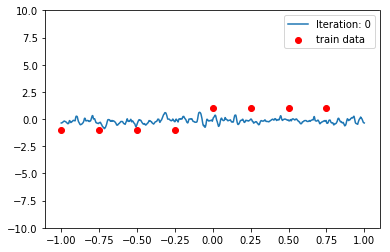

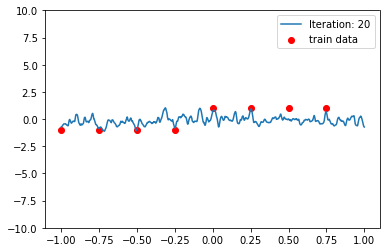

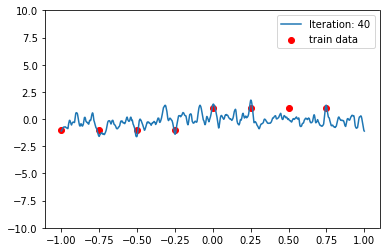

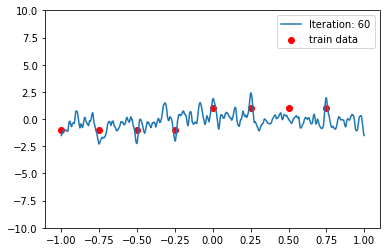

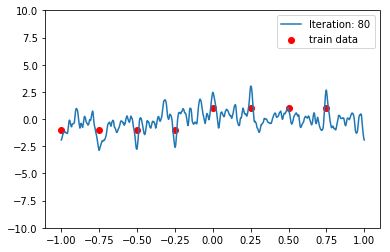

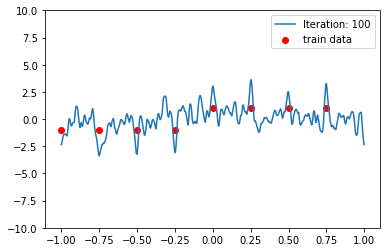

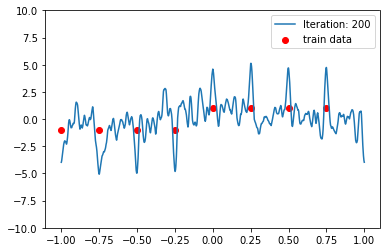

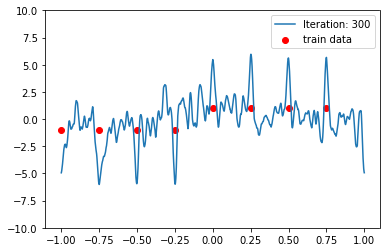

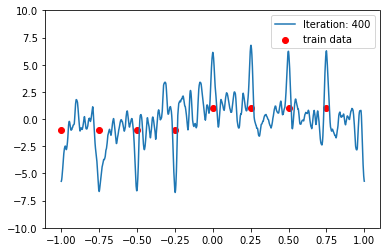

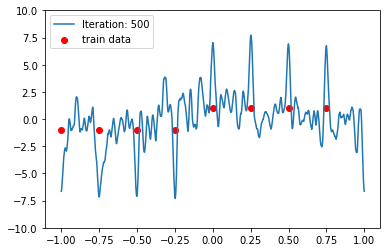

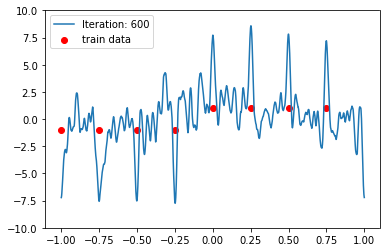

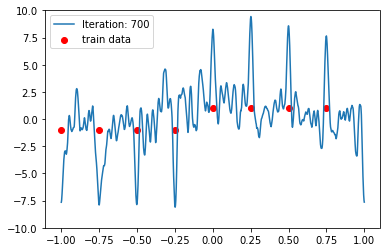

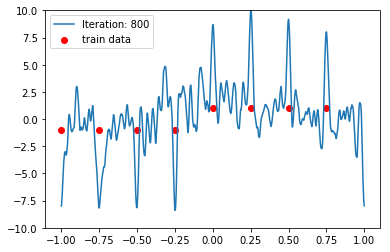

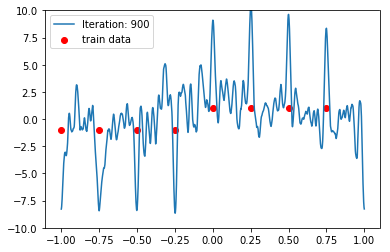

In [30]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-100]

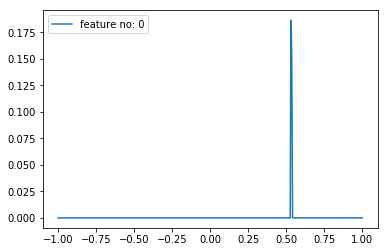

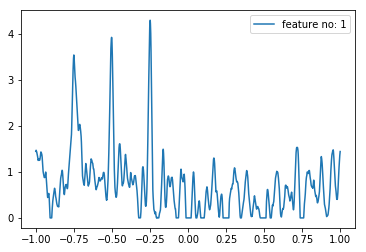

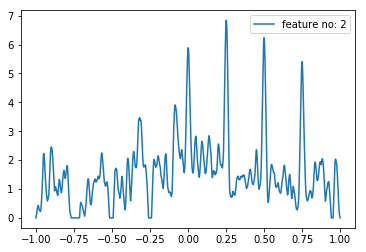

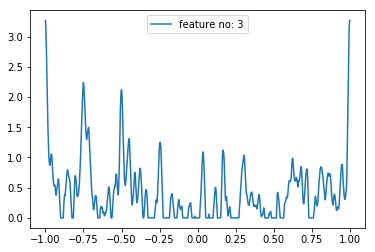

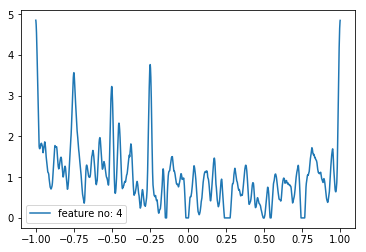

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()